In [8]:
import jax
import jax.numpy as jnp
import numpy as np
from flax import linen as nn
import optax
import matplotlib.pyplot as plt
from pathlib import Path
import common_jax_utils as cju
from typing import Union
from tqdm import tqdm
import wandb
import ml_collections
key = jax.random.PRNGKey(12398)
key_gen = cju.key_generator(key)

print(Path.cwd())

/home/ovindar/PycharmProjects/INR_BEP/flax_exp


In [72]:
def set_config():
    config = ml_collections.ConfigDict()
    config.lr = 0.0005
    config.num_epochs = 3
    config.batch_size = 1024


    config.in_features = 2
    config.out_features = 3
    
    config.num_layers = 3
    config.hidden_features = 1024
    
    
    config.s0 = 5
    config.w0 = 5
    return config

In [73]:
def image_loader():
    parent = Path.cwd().parent
    parrot = parent / 'example_data' / 'parrot.png'
    parrot = plt.imread(parrot)
    parrot = jnp.array(parrot)
    return parrot


def kirby():
    parent = Path.cwd().parent
    kirby = parent / 'example_data' / 'kirby.png'
    kirby = plt.imread(kirby)
    kirby = jnp.array(kirby)
    return kirby

def data_format():
    # y = image_loader()
    y = kirby()
    dims = y.shape
    x = jnp.array(np.meshgrid(np.arange(y.shape[0]), np.arange(y.shape[1]), indexing='ij')).T.reshape(-1, 2)
    y = y.reshape(-1, 3)
    return x, y, dims


# def data_loader(batch_size, key):
#     x, y, _= data_format()
#     together = jnp.concatenate([x, y], axis=1)
#     key, subkey = jax.random.split(key)
#     shuffled = jax.random.permutation(subkey, together)
#     x, y = jnp.split(shuffled, [2], axis=1)
#     for i in range(0, len(x), batch_size):
#         yield x[i:i+batch_size], y[i:i+batch_size]
    
def data_loader(batch_size, key):
    x, y, _= data_format()
    key, subkey = jax.random.split(key)
    shuffled = jax.random.permutation(subkey, jnp.arange(x.shape[0]))
    x = x[shuffled]
    y = y[shuffled]
    for i in range(0, len(x), batch_size):
        yield x[i:i+batch_size], y[i:i+batch_size]
    



In [74]:
def complex_kernel_initialization(rng, shape, dtype):
    key, subkey = jax.random.split(rng)
    real = jax.random.normal(key, shape, dtype=dtype)
    key, subkey = jax.random.split(key)
    imag = jax.random.normal(key, shape, dtype=dtype)
    return (real + jnp.imag(imag))/jnp.sqrt(shape[0])

def complex_input_kernel_initialization(rng, shape, dtype):
    key, w_key = jax.random.split(rng)
    in_size = shape[0]
    lim = 1./in_size# from https://github.com/vsitzmann/siren/blob/4df34baee3f0f9c8f351630992c1fe1f69114b5f/modules.py#L630

    
    real = jax.random.uniform(
        key=w_key,
        shape=shape,
        minval=-lim, 
        maxval=lim,
        dtype=dtype
        )
    imag = jax.random.uniform(
        key=w_key,
        shape=shape,
        minval=-lim, 
        maxval=lim,
        dtype=dtype
        )
    
    return real + jnp.imag(imag)
    

def complex_kernel_initialization2(rng, shape, dtype):
    key, w_key = jax.random.split(rng)
    in_size = shape[0]
    lim = jnp.sqrt(6./in_size)/config.w0  # from https://arxiv.org/pdf/2006.09661.pdf subsection.3.2 and appendix 1.5 and https://github.com/vsitzmann/siren/blob/4df34baee3f0f9c8f351630992c1fe1f69114b5f/modules.py#L627
    
    real = jax.random.uniform(
        key=w_key,
        shape=shape,
        minval=-lim, 
        maxval=lim,
        dtype=dtype
        )
    imag = jax.random.uniform(
        key=w_key,
        shape=shape,
        minval=-lim, 
        maxval=lim,
        dtype=dtype
        )
    
    return real + jnp.imag(imag)
    
            

def complex_wire(x: jax.Array, s0:Union[float, jax.Array], w0:Union[float, jax.Array]):
    """
    Implements a complex version of WIRE
    that is exp(j*w0*x)*exp(-|s0*x'|^2)
    from https://arxiv.org/pdf/2301.05187

    :parameter x: a bunch of `jax.Array`s to be fed to this activation function
        var positional
    :parameter s0: inverse scale used in the radial part of the wavelet (s_0 in the paper)
        keyword only
    :parameter w0: w0 parameter used in the rotational art of the wavelet (\omega_0 in the paper)
        keyword only
    :return: a `jax.Array` with a shape determined by broadcasting all elements of x to tha same shape
    """
    radial_part = jnp.exp(
        -jnp.square(
            jnp.abs(
                s0 * x
            )
        )
    )
    rotational_part = jnp.exp(jnp.imag(w0 * x))

    return rotational_part*radial_part

def unscaled_gaussian_bump(*x:jax.Array, inverse_scale:Union[float, jax.Array]):
    """ 
    e^(sum_{x' in x}-|inverse_scale*x'|^2)

    :param x: sequence of arrays for which to calculate the gaussian bump
    :returns: the product of the gaussian bumps (computed as a sum in log-space)
    """
    x = jnp.stack(x, axis=0)
    if jnp.isrealobj(x):
        scaled_x = inverse_scale*x
    else:
        scaled_x = jnp.abs(inverse_scale*x)
    return jnp.exp(-jnp.sum(jnp.square(scaled_x), axis=0))


def real_wire(*x: jax.Array, s0:Union[float, jax.Array], w0:Union[float, jax.Array]):
    """ 
    Implements a real version of WIRE-nD
    that is sin(w0*x[0])*exp(-\sum_{x' in x}|inverse_scale*x'|^2)
    from https://arxiv.org/pdf/2301.05187

    :parameter x: a bunch of `jax.Array`s to be fed to this activation function
        var positional
    :parameter s0: inverse scale used in the radial part of the wavelet (s_0 in the paper)
        keyword only
    :parameter w0: w0 parameter used in the rotational art of the wavelet (\omega_0 in the paper)
        keyword only
    :return: a `jax.Array` with a shape determined by broadcasting all elements of x to tha same shape
    """
    radial_part = unscaled_gaussian_bump(*x, inverse_scale=s0)
    rotational_part = jnp.sin(w0*x[0])
    return rotational_part*radial_part

In [75]:

class ComplexDense(nn.Module):
    
    in_features: int = 2
    hidden_features: int = 256
    out_features: int = 3
    num_layers: int = 5
    s0: float = 12
    w0: float = 10
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(
            features=self.hidden_features,
            kernel_init=complex_input_kernel_initialization,
            bias_init=complex_input_kernel_initialization,
            name='input_layer'
        )(x)
        x = complex_wire(x, self.s0, self.w0)
        for i in range(self.num_layers-1):
            x = nn.Dense(
                features=self.hidden_features,
                kernel_init=complex_kernel_initialization2,
                bias_init=complex_kernel_initialization2,
                name=f'fc{i}'
            )(x)
            x = complex_wire(x, self.s0, self.w0)
        
        x = nn.Dense(
            features=self.out_features,
            kernel_init=complex_kernel_initialization2,
            bias_init=complex_kernel_initialization2,
            name='output_layer'
        )(x)
        # x = real_wire(x, s0=self.s0, w0=self.w0)
        x = complex_wire(x, s0=self.s0, w0=self.w0)
        
        
        return x
    
    
config = set_config()
model = ComplexDense(
    in_features=config.in_features,
    hidden_features=config.hidden_features,
    out_features=config.out_features,
    num_layers=config.num_layers,
    s0=config.s0,
    w0=config.w0
)



In [76]:

def mse_loss(pred, true):
    return jnp.mean(jnp.square(pred - true))
    

def loss_fn(params, x, true_val, eps=1e-6):
    """Mean squared error loss."""
    pred_val = model.apply(params, x)
    mse = mse_loss(pred_val, true_val)
    # mean_true_val = true_val.mean(axis=0, keepdims=True)
    # scaling = mse_loss(mean_true_val, true_val)
    # return mse/(scaling + eps)
    return mse



def update(params, x, y, opt, opt_state):
    """
    Compute the gradient for a batch and update the parameters.
    """
    loss, grads = jax.value_and_grad(loss_fn)(params, x, y)   
    updates, opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state, loss

def render_and_save_image(params, epoch):
    path = Path.cwd() / f'epoch_{epoch}.png'
    pred_ys, _ = test(params, 1)
    sh = data_format()[2]
    pred_ys = pred_ys.reshape(sh)
    plt.imsave(path, pred_ys)
    return pred_ys
    

def train(params, opt, opt_state, num_epochs, batch_size, key):
    """
    Train the model for a number of epochs.
    """
    
    for epoch in tqdm(range(num_epochs)):
        
        key, subkey = jax.random.split(key)
        dl = data_loader(batch_size, key)
        
        for x, y in dl:
            params, opt_state, loss = update(params, x, y, opt, opt_state)
            
            if jnp.isnan(loss):
                raise ValueError('Loss is NaN')
            if loss <0.05:
                break
        
        render_and_save_image(params, epoch)
        if epoch % 10 == 0:
            print(f'Epoch: {epoch}, Loss: {loss}')
        wandb.log({'loss': loss, 'epoch': epoch})
        
    return params

def train_max_steps(params, opt, opt_state, num_steps, batch_size, key):
    """
    Train the model for a number of epochs.
    """
    
    dl = data_loader(batch_size, key)
    for i in tqdm(range(num_steps)):
        key, subkey = jax.random.split(key)
        x, y = next(dl)
        if x is None:
            dl = data_loader(batch_size, key)
            x, y = next(dl)
            
        
        params, opt_state, loss = update(params, x, y, opt, opt_state)
        if jnp.isnan(loss):
            raise ValueError('Loss is NaN')
        if i % 1000 == 0:
            print(f'Step: {i}, Loss: {loss}')
        wandb.log({'loss': loss, 'step': i})
        
    return params


def test(params, batch_size):
    x, y, _ = data_format()
 
    
    pred_ys = model.apply(params, x)
    loss = loss_fn(params, x, y)
    return pred_ys, loss
    
        

def main():
    wandb.init(project='flax_wire')
    
    config = set_config()
    key = jax.random.PRNGKey(0)
    lr = config.lr
    num_epochs = config.num_epochs
    batch_size = config.batch_size
    
    
    wandb.config.update(config)

    
    params = model.init(next(key_gen), jnp.ones((1, 2)))
    
    print(model)
    
    # print the model summary
    
    
    
    opt = optax.adam(lr)
    
    opt_state = opt.init(params)
    
    trained_params = train(
        params=params,
        opt=opt,
        opt_state=opt_state,
        num_epochs=num_epochs,
        batch_size=batch_size,
        key=key
    )

        
    pred_ys, test_loss = test(
        params=trained_params,
        batch_size=batch_size
    )
    print(f'Training Done, Test Loss: {test_loss}')
    wandb.log({'test_loss': test_loss})
    pred_ys = pred_ys.reshape(data_format()[2])
    
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(pred_ys)
    ax[1].imshow(kirby())
    plt.show()
    
    
    
    

    return pred_ys

epoch,▁▅█
loss,▁▆█
test_loss,▁
epoch,2
loss,0.1415
test_loss,0.13721


ComplexDense(
    # attributes
    in_features = 2
    hidden_features = 1024
    out_features = 3
    num_layers = 3
    s0 = 5
    w0 = 5
)


 33%|███▎      | 1/3 [00:04<00:08,  4.27s/it]

Epoch: 0, Loss: 0.23510637879371643


100%|██████████| 3/3 [00:08<00:00,  2.93s/it]


Training Done, Test Loss: 0.144795224070549


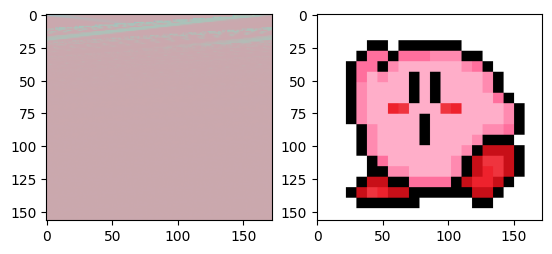

In [77]:
pys = main()